## Redes Bayesianas

### Introdução
Redes Bayesianas são modelos que usam probabilidade pra representar relações entre variáveis. Elas ajudam a prever eventos com base em dados conhecidos, mesmo quando há incertezas.

Neste projeto, a ideia é aplicar redes bayesianas pra prever enchentes em São Luís. As variáveis usadas incluem precipitação nas últimas 24h, intensidade e duração da chuva, nível da maré, bairro, topografia e qualidade da drenagem Com isso, é possível calcular a probabilidade de alagamento em determinadas regiões, ajudando na prevenção e tomada de decisões.

## Setup - Instalações e Importações

Esta célula instala as bibliotecas necessárias e carrega os dados do GitHub.


---



In [ ]:
!pip install pgmpy
#Importando bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# pgmpy - Redes Bayesianas
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import PC


#Datasets no GitHub
url_principal = 'https://raw.githubusercontent.com/hissa02/Redes-Bayesianas/Hissa/Codigo/Dataset/sao_luis_eventos_climaticos_limpo.csv'
url_pequeno = 'https://raw.githubusercontent.com/hissa02/Redes-Bayesianas/Hissa/Codigo/Dataset/sao_luis_enchentes_limpo.csv'


##Tabela para pré-visualização
Essa tabela mostra alguns dados retirados dos Datasets


---

In [33]:
# Carrega dataset de eventos climáticos em São Luís
df = pd.read_csv('https://raw.githubusercontent.com/hissa02/Redes-Bayesianas/Hissa/Codigo/Dataset/sao_luis_eventos_climaticos_limpo.csv')

# Carrega dataset de enchentes em São Luís
df = pd.read_csv('https://raw.githubusercontent.com/hissa02/Redes-Bayesianas/Hissa/Codigo/Dataset/sao_luis_enchentes_limpo.csv')

# Mostra 10 primeiras linhas do dataset
df.head(10)


,precipitacao_mm,intensidade_chuva,duracao_chuva,mare,bairro,topografia,drenagem,enchente
0,85.2,intensa,6h+,alta,Centro,baixa,inadequada,True
1,45.1,moderada,2-6h,média,Vinhais,média,adequada,False
2,92.7,intensa,6h+,alta,João Paulo,baixa,inadequada,True
3,23.5,fraca,<2h,baixa,Renascença,alta,adequada,False
4,67.8,intensa,2-6h,média,Cohama,baixa,regular,True
5,15.2,fraca,<2h,baixa,Alemanha,média,regular,False
6,76.3,intensa,6h+,alta,São Francisco,baixa,inadequada,True
7,38.9,moderada,2-6h,baixa,Calhau,baixa,regular,False
8,55.1,intensa,2-6h,alta,Centro,baixa,inadequada,True
9,29.7,fraca,2-6h,média,Vinhais,média,adequada,False


##Estimar estrutura
Esta célula mostra as principais variáveis que influenciam na probabilidade de enchente

---



In [34]:
est = PC( df )
modelo_estimado = est.estimate(variant = 'stable' , max_cond_vars=4)
print("Estrutura estimada:")
print(modelo_estimado.edges())

print("\nNós da rede:")
print(modelo_estimado.nodes())


  0%|          | 0/5 [00:00<?, ?it/s]

Estrutura estimada:
[('drenagem', 'enchente'), ('drenagem', 'bairro'), ('drenagem', 'topografia'), ('enchente', 'drenagem'), ('bairro', 'drenagem'), ('bairro', 'topografia'), ('topografia', 'bairro'), ('topografia', 'drenagem')]

Nós da rede:
['drenagem', 'enchente', 'bairro', 'topografia', 'mare', 'duracao_chuva', 'intensidade_chuva', 'precipitacao_mm']


##Grafo da rede
Este grafo mostra as principais variáveis que influenciam na probabilidade de enchente


---



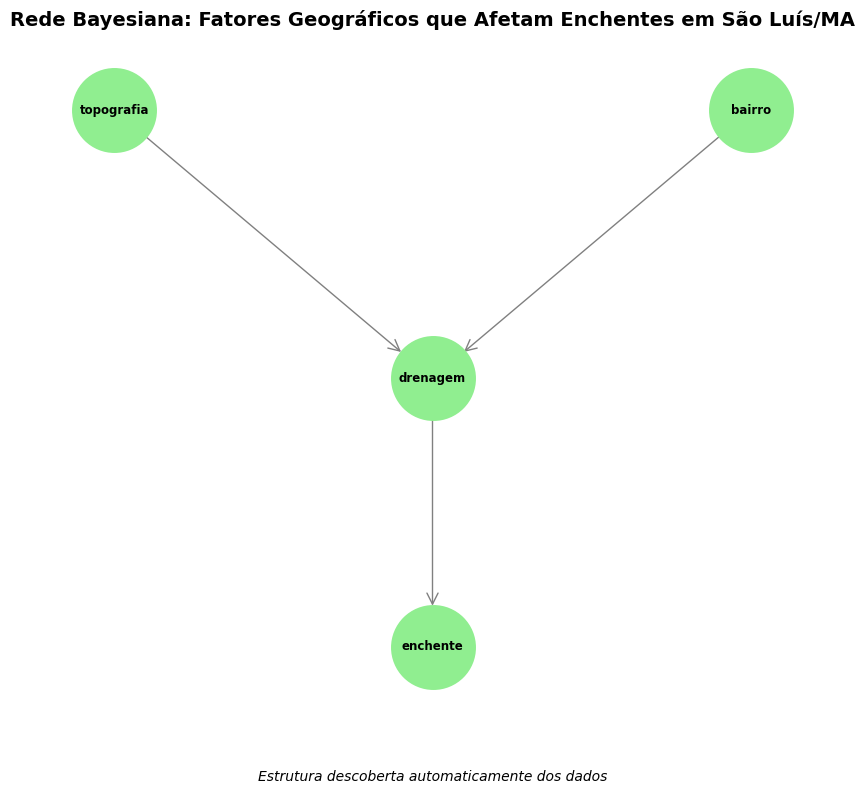


RELAÇÕES CAUSAIS DESCOBERTAS:
• Topografia → Drenagem
• Bairro → Drenagem
• Drenagem → Enchente

A análise dos dados mostra que fatores geográficos são mais determinantes.


In [35]:
# Definir a estrutura da rede baseada na descoberta automática
# Drenagem → Enchente
# Bairro → Drenagem
# Topografia → Drenagem
model = DiscreteBayesianNetwork([
    ('drenagem', 'enchente'),
    ('bairro', 'drenagem'),
    ('topografia', 'drenagem')
])

# Criar o grafo para visualização
plt.figure(figsize=(8, 8))

# Converter para NetworkX para plotar
G = nx.DiGraph()
G.add_edges_from(model.edges())

# Definir posições dos nós manualmente para melhor visualização
pos = {
    'topografia': (-1, 1),
    'bairro': (1, 1),
    'drenagem': (0, 0),
    'enchente': (0, -1)
}

# Desenhar o grafo
plt.subplot(111)
nx.draw(G, pos,
        with_labels=True,
        node_color='lightgreen',
        node_size=3500,
        font_size=8.5,
        font_weight='bold',
        arrows=True,
        arrowsize=20,
        arrowstyle='->',
        edge_color='gray',
        linewidths=2)

plt.title('Rede Bayesiana: Fatores Geográficos que Afetam Enchentes em São Luís/MA',
          fontsize=14, fontweight='bold', pad=20)

# Adicionar legenda
plt.text(0, -1.5, 'Estrutura descoberta automaticamente dos dados',
         ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.show()

# Mostrar informações sobre a rede
print("\nRELAÇÕES CAUSAIS DESCOBERTAS:")
print("• Topografia → Drenagem")
print("• Bairro → Drenagem")
print("• Drenagem → Enchente")
print("\nA análise dos dados mostra que fatores geográficos são mais determinantes.")